In [1]:
import pandas_datareader.data as web
import datetime

In [2]:
start=datetime.datetime(2000,1,1)
end=datetime.datetime(2021,9,1)

In [3]:
df=web.DataReader('GOOGL','stooq',start,end)

In [24]:
df.dropna(inplace=True)#要删掉空值，否则测试数据有问题,重试便发现少了数据（空值的）
df.sort_index(inplace=True)
pre_days=10
df['label']=df['Close'].shift(-pre_days)
print(df)

                 Open      High        Low      Close       Volume    label
Date                                                                       
2004-08-19    2.50000    2.6015    2.39900    2.50850  894076000.0  2.53775
2004-08-20    2.52525    2.7270    2.51250    2.70775  457144000.0  2.50025
2004-08-23    2.76875    2.8370    2.72625    2.73500  365488000.0  2.53950
2004-08-24    2.78100    2.7900    2.58925    2.62175  305252000.0  2.55750
2004-08-25    2.62400    2.7000    2.59700    2.65000  183956000.0  2.55775
...               ...       ...        ...        ...          ...      ...
2021-07-29  136.15000  136.6610  135.54300  135.77800   31715720.0      NaN
2021-07-30  135.03500  135.3050  134.25500  134.72700   25575780.0      NaN
2021-08-02  135.11700  135.3360  133.79400  134.85400   21634200.0      NaN
2021-08-03  135.13500  135.7320  133.32000  135.63000   20761880.0      NaN
2021-08-04  135.34900  135.6500  134.48700  135.12600   19676020.0      NaN

[4269 rows 

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scaler=StandardScaler()
sca_x=scaler.fit_transform(df.iloc[:,:-1])
print(sca_x)

[[-1.11067092 -1.10764158 -1.11272425 -1.10946028  4.8881565 ]
 [-1.10967557 -1.10274125 -1.10820951 -1.10161352  2.08531725]
 [-1.1000769  -1.09844615 -1.09970708 -1.10054037  1.4973607 ]
 ...
 [ 4.11703935  4.07516877  4.11383131  4.10250509 -0.70839884]
 [ 4.11774891  4.09063116  4.09497681  4.13306514 -0.71399461]
 [ 4.1261847   4.08742935  4.14139707  4.11321686 -0.72096021]]


In [27]:
from collections import deque

In [40]:
#memory_days=5
#若把记忆时间放长，查看测试效果
memory_days=10
deq=deque(maxlen=memory_days)

In [41]:
x=[]
for i in sca_x:
    deq.append(i)
    if len(deq)==memory_days:
        x.append(list(deq))

x_lately=x[-pre_days:]
x=x[:-pre_days]
print(len(x))
print(len(x_lately))

4250
10


In [42]:
y=df['label'].values[memory_days-1:-pre_days]
print(len(y))

4250


In [44]:
import numpy as np

In [45]:
x=np.array(x)
y=np.array(y)
print(x.shape)
print(y.shape)

(4250, 10, 5)
(4250,)


In [46]:
#划分测试集和训练集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.1)

In [47]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [48]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#构建LSTM神经网络
model=Sequential()
#10个神经单元,激活函数：relu，循环神经网络所以return_sequences=True
model.add(LSTM(10,input_shape=x.shape[1:],activation='relu',return_sequences=True))
#防止过拟合 删除0.1的神经元
model.add(Dropout(0.1))
#构建第二层
model.add(LSTM(10,activation='relu',return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(10,activation='relu'))
model.add(Dropout(0.1))
#构建全连接层
model.add(Dense(10,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1))
#编译 优化器adam，损失函数mse平均方差，评价函数mape
model.compile(optimizer='adam',
             loss='mse',
             metrics=['mape'])

In [49]:
##初步训练模型  validation_data:校验的数据集
model.fit(X_train,y_train,batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
120/120 [==============================] - 4s 17ms/step - loss: 825.5714 - mape: 68.1166 - val_loss: 25.0202 - val_mape: 18.6133
Epoch 2/50
120/120 [==============================] - 2s 16ms/step - loss: 126.8309 - mape: 28.1348 - val_loss: 38.0758 - val_mape: 18.2544
Epoch 3/50
120/120 [==============================] - 2s 13ms/step - loss: 99.5389 - mape: 23.7518 - val_loss: 18.9338 - val_mape: 17.0376
Epoch 4/50
120/120 [==============================] - 2s 14ms/step - loss: 99.8140 - mape: 22.8975 - val_loss: 13.0449 - val_mape: 14.4855
Epoch 5/50
120/120 [==============================] - 2s 13ms/step - loss: 97.2060 - mape: 21.9474 - val_loss: 22.3363 - val_mape: 14.4877
Epoch 6/50
120/120 [==============================] - 2s 13ms/step - loss: 83.6372 - mape: 21.5469 - val_loss: 11.4455 - val_mape: 14.6085
Epoch 7/50
120/120 [==============================] - 2s 13ms/step - loss: 76.0091 - mape: 20.2092 - val_loss: 18.8416 - val_mape: 13.1386
Epoch 8/50
120/120 [=====

In [2]:
import pandas_datareader.data as web  #https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-stooq
import datetime

#设定开始时间和结束时间
start=datetime.datetime(2000,1,1)  
end=datetime.datetime(2021,9,1)
df=web.DataReader('GOOGL','stooq',start,end)
#数据预处理  优化

def Stock_Price_LSTM_Data_Precessing(df,memory_days,pre_days):
    df.dropna(inplace=True)#要删掉空值，否则测试数据有问题,重试便发现少了数据（空值的）
    df.sort_index(inplace=True)
    
    df['label']=df['Close'].shift(-pre_days)  #label是收盘价向上移10天
    
    #数据标准化
    from sklearn.preprocessing import StandardScaler
    scaler=StandardScaler()
    sca_x=scaler.fit_transform(df.iloc[:,:-1])
    
    from collections import deque
    deq=deque(maxlen=memory_days)
    
    x=[]
    for i in sca_x:
        deq.append(i)
        if len(deq)==memory_days:
            x.append(list(deq))

    x_lately=x[-pre_days:]
    x=x[:-pre_days]
    
    y=df['label'].values[memory_days-1:-pre_days]

    import numpy as np
    x=np.array(x)
    y=np.array(y)
    
    return x,y,x_lately

In [3]:
x,y,x_lately=Stock_Price_LSTM_Data_Precessing(df,5,10)

In [4]:
print(len(x))
print(len(y))
print(len(x_lately))

4275
4275
10


In [20]:

from tensorflow.keras.callbacks import ModelCheckpoint

#memory_days=[5,10,15]
#lstm_layers=[1,2,3]
#dense_layers=[1,2,3]
#units=[16,32]#神经元
memory_days=[5]    #记忆5天，5天数据作为输入
lstm_layers=[1]
dense_layers=[1]
units=[32]#神经元
pre_days=10         #预测10天后的数据  比如：8月10日预测8月20日数据，把8月5日--8月10日数据作为输入
#callbacks用transform 能在每一次训练中找到最优的模型（https://keras.io/api/callbacks/model_checkpoint/）
for the_men_days in memory_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:        #{epoch:02d}【：第几期】-{val_loss:.2f}.hdf5【：偏差率】中loss改mape
                checkpoint_filepath='./modelsAgain/{val_mape:.2f}.hdf5_{epoch:02d}_'+f'men_{the_men_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_units_{the_units}'
                
                Checkpoint=ModelCheckpoint(
                    filepath=checkpoint_filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True)

                x,y,x_lately=Stock_Price_LSTM_Data_Precessing(df,the_men_days,pre_days)
                #划分测试集和训练集
                from sklearn.model_selection import train_test_split
                X_train,X_test,y_train,y_test=train_test_split(x,y,shuffle=False,test_size=0.1)#循序不打乱

                
                
                import tensorflow
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM, Dense, Dropout

                #构建LSTM神经网络
                model=Sequential()
                #10个神经单元,激活函数：relu，循环神经网络所以return_sequences=True
                model.add(LSTM(the_units,input_shape=x.shape[1:],activation='relu',return_sequences=True))
                #防止过拟合 删除0.1的神经元
                model.add(Dropout(0.1))
                
                for i in range(the_lstm_layers):
                    #构建第二层
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))

                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0.1))
                
                for i in range(the_dense_layers):
                    #构建全连接层
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))
                #编译 优化器adam，损失函数mse平均方差，评价函数mape
                model.compile(optimizer='adam',
                             loss='mse',
                             metrics=['mape'])
                model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test),callbacks=[Checkpoint])

Epoch 1/50
105/105 [==============================] - 4s 12ms/step - loss: 287.6686 - mape: 70.7748 - val_loss: 380.2642 - val_mape: 30.7549
INFO:tensorflow:Assets written to: ./modelsAgain\30.75.hdf5_01_men_5_lstm_1_dense_1_units_32\assets
Epoch 2/50
105/105 [==============================] - 1s 10ms/step - loss: 25.0390 - mape: 25.7248 - val_loss: 19.0348 - val_mape: 5.9218
INFO:tensorflow:Assets written to: ./modelsAgain\5.92.hdf5_02_men_5_lstm_1_dense_1_units_32\assets
Epoch 3/50
105/105 [==============================] - 1s 10ms/step - loss: 14.8133 - mape: 17.7049 - val_loss: 8.5296 - val_mape: 4.2719
INFO:tensorflow:Assets written to: ./modelsAgain\4.27.hdf5_03_men_5_lstm_1_dense_1_units_32\assets
Epoch 4/50
105/105 [==============================] - 1s 10ms/step - loss: 11.9039 - mape: 13.7459 - val_loss: 10.6871 - val_mape: 4.5080
Epoch 5/50
105/105 [==============================] - 1s 10ms/step - loss: 10.4752 - mape: 13.5050 - val_loss: 9.1666 - val_mape: 4.4822
Epoch 6/50


In [21]:
from tensorflow.keras.models import load_model
best_model=load_model('./models/3.57.hdf5_33_men_15_lstm_1_dense_1_units_32')

OSError: SavedModel file does not exist at: ./models/3.71.hdf5_48_men_5_lstm_1_dense_1_units_32\{saved_model.pbtxt|saved_model.pb}

In [8]:
#best_model.summary()
#best_model.evaluate(X_test,y_test)
pre=best_model.predict(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

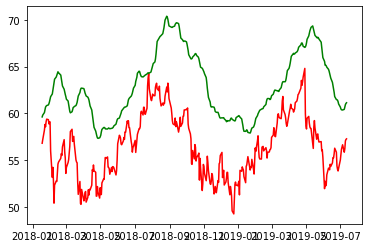

In [10]:
import matplotlib.pyplot as plt

df_time=df.index[-len(y_test):]
plt.plot(df_time,y_test,color='red',label='price')#实际值图像
plt.plot(df_time,pre,color='green',label='predict')#预测值图像
plt.show


In [23]:
from tensorflow.keras.models import load_model
best_model=load_model('./modelsAgain/3.71.hdf5_48_men_5_lstm_1_dense_1_units_32')

In [24]:
#best_model.summary()
#best_model.evaluate(X_test,y_test)
pre=best_model.predict(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

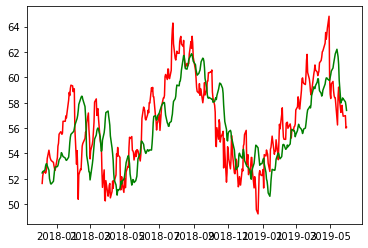

In [25]:
import matplotlib.pyplot as plt

df_time=df.index[-len(y_test):]
plt.plot(df_time,y_test,color='red',label='price')#实际值图像
plt.plot(df_time,pre,color='green',label='predict')#预测值图像
plt.show